<a href="https://colab.research.google.com/github/dsdoris/DS/blob/master/n234a_interpreting_ml_model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 3 / NOTE 4*

# 📝 Assignment
---

# Interpreting ML Model

### 1) 지속적으로 포트폴리오 프로젝트를 수행하세요
- 지속적으로 데이터를 랭글링 하고 추가적인 시각화 결과를 만드세요

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [ ]:
# Kaggle Dataset 사용
# Hotel booking demand(https://www.kaggle.com/jessemostipak/hotel-booking-demand)
# - information(https://doi.org/10.1016/j.dib.2018.11.126)

import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/dsdoris/DS/master/data/hotel_bookings.csv')

In [ ]:
# feature engineering

# allchildren = babies + children
df['allchildren'] = df['babies'] + df['children']
df = df.drop(columns=['babies', 'children'])

# 2박 이상 머문 경우와 아닌 경우
stay_nights = []
for i in range(len(df)):
  nights = df['stays_in_weekend_nights'][i] + df['stays_in_week_nights'][i]
  if nights > 1:
    stay_nights.append(1)
  else:
    stay_nights.append(0) 

df['stay_nights'] = stay_nights

# 결측치가 많은 특성 제거
df = df.drop(columns=['agent', 'company'])

# 예약(취소,퇴실 등)정보를 가지고 있는 특성 제거
df = df.drop(columns=['reservation_status','reservation_status_date'])



In [ ]:
# 데이터 나누기 (학습(64%), 검증(16%), 테스트(20%) 데이터)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

print(train.shape, val.shape, test.shape)

(76409, 28) (19103, 28) (23878, 28)


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76409 entries, 115711 to 27158
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           76409 non-null  object 
 1   is_canceled                     76409 non-null  int64  
 2   lead_time                       76409 non-null  int64  
 3   arrival_date_year               76409 non-null  int64  
 4   arrival_date_month              76409 non-null  object 
 5   arrival_date_week_number        76409 non-null  int64  
 6   arrival_date_day_of_month       76409 non-null  int64  
 7   stays_in_weekend_nights         76409 non-null  int64  
 8   stays_in_week_nights            76409 non-null  int64  
 9   adults                          76409 non-null  int64  
 10  meal                            76409 non-null  object 
 11  country                         76103 non-null  object 
 12  market_segment             

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

target = 'is_canceled'
features = df.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# XGBoost 모델
!pip install xgboost
from xgboost import XGBClassifier

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=7,
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error',  #(wrong cases)/#(all cases)
          early_stopping_rounds=50  # 50 rounds 동안 스코어의 개선이 없으면 멈춤
         ) 

[0]	validation_0-error:0.19109	validation_1-error:0.191436
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.190122	validation_1-error:0.18997
[2]	validation_0-error:0.189768	validation_1-error:0.189813
[3]	validation_0-error:0.181981	validation_1-error:0.180338
[4]	validation_0-error:0.184769	validation_1-error:0.184212
[5]	validation_0-error:0.179495	validation_1-error:0.178506
[6]	validation_0-error:0.17689	validation_1-error:0.177407
[7]	validation_0-error:0.175843	validation_1-error:0.175941
[8]	validation_0-error:0.173042	validation_1-error:0.173219
[9]	validation_0-error:0.170674	validation_1-error:0.170444
[10]	validation_0-error:0.168998	validation_1-error:0.168298
[11]	validation_0-error:0.167035	validation_1-error:0.166989
[12]	validation_0-error:0.164784	validation_1-error:0.164267
[13]	validation_0-error:0.163803	validation_1-error:0.16411

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(X_val_encoded)

print('검증 정확도', model.score(X_val_encoded, y_val))
print(classification_report(y_val, y_pred))

검증 정확도 0.8861958854630163
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     11928
           1       0.87      0.82      0.84      7175

    accuracy                           0.89     19103
   macro avg       0.88      0.87      0.88     19103
weighted avg       0.89      0.89      0.89     19103



### 2) PDP를 만들어 모델을 설명하세요
- 한 특성에 대한 PDP를 만들고 모델을 설명하세요
- 두 특성간 관계에 대한 PDP를 만들고 모델을 설명하세요


In [23]:
# 그래프 화질 조정
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

In [17]:
!pip install PDPbox
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'lead_time'

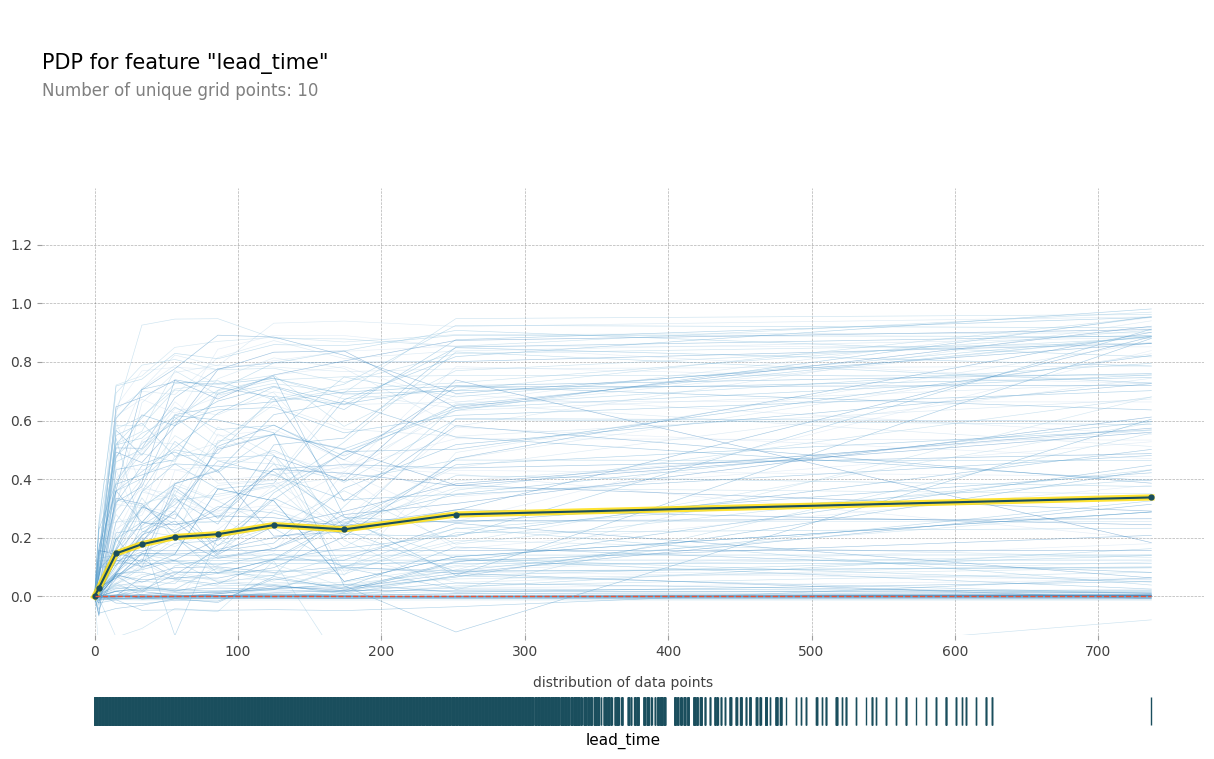

In [25]:
# 한 특성에 대한 PDP를 만들고 모델을 설명
isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 # ICE curves는 100개
         , plot_pts_dist=True);

> PDP를 통해서 개별 특성과 타겟간의 관계를 파악할 수 있다.
>
> 위 그래프를 통해서 예약부터 도착일까지의 기간(lead_time)이 길어지면 , 취소할(is_canceled:target) 가능성도 어느 정도 상승하는 것으로 볼 수 있다. (+방향으로 영향)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


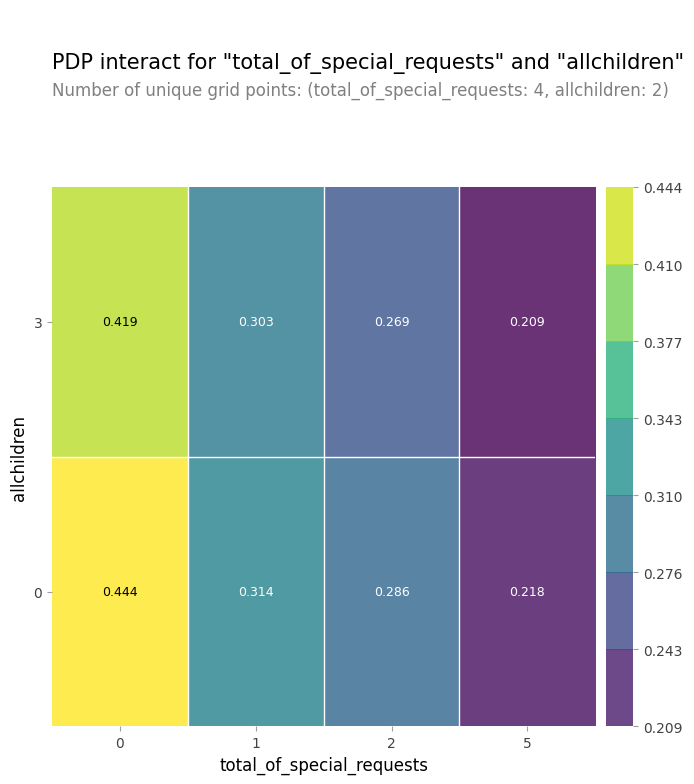

In [29]:
#두 특성간 관계에 대한 PDP를 만들고 모델을 설명
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['total_of_special_requests', 'allchildren']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

> 예약한 고객 중 어린이(allchildren)가 많으면 따로 요청하는 사항들(total_of_special_requests)도 많아지는 것을 알 수 있다.

### 3) SHAP 라이브러리를 사용해 최소 3개 이상 시각화를 하고 분석하세요

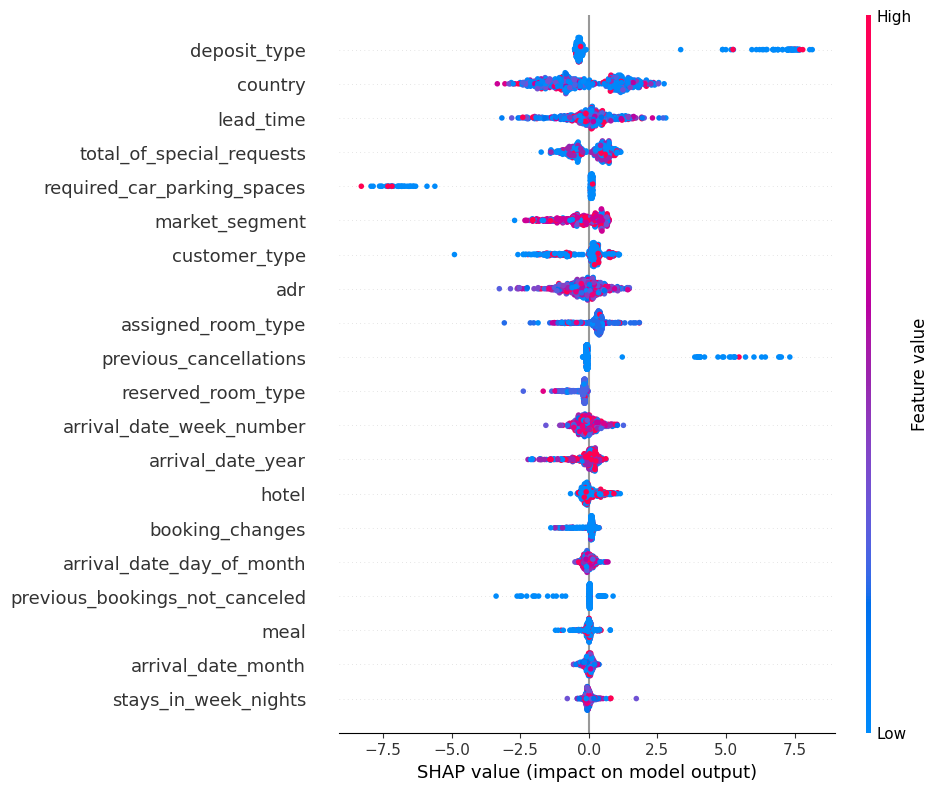

In [58]:
# 앞 500개 데이터의 특성별 shap value 살펴보기
shap_values = explainer.shap_values(X_test_encoded.iloc[:500])
shap.summary_plot(shap_values, X_train_encoded.iloc[:500])

> shap value가 음수 방향에서 주로 나타나는 예치금 납입방법(deposit_type), 이전 취소 이력 있음(previous_cancellations)와 같은 특성은 예측 결과를 취소할 것이라는 방향으로 내는 데 영향을 준다.
>
> 반대로, shap value가 양수 방향에서 주로 나타나는 주차공간 요청(required_car_parking_spaces), 이전 취소이력 없음(previous_bookings_not_canceled)과 같은 특성은 예측 결과를 취소하지 않을 것이라는 방향으로 내는 데 영향을 줄 것이다. 

In [39]:
# 임의 값을 넣어 모델의 예측을 설명해보기
row = X_test_encoded.iloc[[1]]

print("예측에 사용할 특성값:\n", row)
print("\n* 예측값:", model.predict(row))
print("\n* 실제값:", y_test.iloc[[1]])

예측에 사용할 특성값:
        hotel  lead_time  ...  allchildren  stay_nights
46713      1         12  ...          0.0            1

[1 rows x 27 columns]

* 예측값: [0]

* 실제값: 46713    0
Name: is_canceled, dtype: int64


In [40]:
!pip install shap==0.36.0 # shap 설치
import shap

shap.initjs() # shap 실행 전 자바스크립트 준비(초기화)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

     |████████████████████████████████| 327kB 4.6MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456461 sha256=d5c3f30bc61838724fcce1e7b5e5f267facf654e2a25d327c086572bfeac2ddf
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


> 테스트 데이터의 2번째 특성들을 넣어서 예측한 결과, 예측값과 실제 값이 모두 0(취소하지 않음)으로 나타났다.
>
> 위 그래프를 살펴보면 판매된 객실평균요금(ADR), 국가(country)가 취소하지 않는 방향으로 크게 영향을 주는 것으로 나타났고, 요청사항이 없는 것, 도착요일 등은 취소하는 방향으로 비교적 적은 영향을 주었다. 따라서, 모델의 베이스라인인 -0.68보다 작은 -1.96으로 예측값이 0으로 산출되었다.


In [54]:
row2 = X_test_encoded.iloc[[500]]

print("예측에 사용할 특성값:\n", row2)
print("\n* 예측값:", model.predict(row2))
print("\n* 실제값:", y_test.iloc[[500]])

예측에 사용할 특성값:
        hotel  lead_time  ...  allchildren  stay_nights
75430      1        327  ...          0.0            1

[1 rows x 27 columns]

* 예측값: [1]

* 실제값: 75430    1
Name: is_canceled, dtype: int64


In [48]:
shap.initjs()
shap_values = explainer.shap_values(row2)

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row2
)

> 테스트 데이터의 501번째 특성들을 넣어서 예측한 결과, 예측값과 실제 값이 모두 1(취소함)으로 나타났다.
>
> 위 그래프를 살펴보면 예치금 종류(deposit_type), 이전취소이력(previous_cancellations)가 취소하는 방향으로 비교적 아주 크게 영향을 주어 예측값이 1로 산출되었다. 취소하지 않는 방향으로 영향을 준 특성은 고객 유형(customer_type), 판매객실평균요금(ADR) 등이 있으나 비교적 적은 영향을 주어 결과에 기여하지 못한 것으로 추측된다.

In [55]:
row3 = X_test_encoded.iloc[[968]]

print("예측에 사용할 특성값:\n", row3)
print("\n* 예측값:", model.predict(row3))
print("\n* 실제값:", y_test.iloc[[968]])

예측에 사용할 특성값:
        hotel  lead_time  ...  allchildren  stay_nights
12015      2          6  ...          0.0            1

[1 rows x 27 columns]

* 예측값: [0]

* 실제값: 12015    1
Name: is_canceled, dtype: int64


In [56]:
shap.initjs()
shap_values = explainer.shap_values(row3)

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row3
)

> 테스트 데이터의 969번째 특성들을 넣어서 예측한 결과, 예측값은 0(취소안함)이지만 실제 값이 1(취소함)로 나타났다.
>
> 위 그래프를 살펴보면 예약일로부터 도착일까지의 기간(lead_time), 마켓세그먼트(market_segment), 예치금 종류(deposit_type) 등이 취소하지 않는 방향으로 비교적 크게 영향을 주었고, 국가(country), 별도요청사항(total_of_special_request) 등이 있으나 비교적 적은 영향을 주어 모델이 취소하지 않을 것으로 결과를 냈지만 실제와 달랐다.